In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit.ignis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 12.7 MB/s 
     |████████████████████████████████| 19.2 MB 416 kB/s 
     |████████████████████████████████| 240 kB 58.9 MB/s 
     |████████████████████████████████| 106 kB 45.6 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 943 kB 52.3 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 2.6 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 4.1 MB 51.6 MB/s 
     |████████████████████████████████| 1.9 MB 50.4 MB/s 
     |████████████████████████████████| 112 kB 59.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12224 sha256=748b2ffe39503ed8773939d9b9bf3f5e6611a1e568fe73b8ec36302052f2846b
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee5

In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.3 MB/s 
     |████████████████████████████████| 15.3 MB 62.9 MB/s 
     |████████████████████████████████| 145 kB 43.6 MB/s 


In [ ]:

import pennylane as qml
from pennylane import numpy as np
import numpy as np
from qiskit.quantum_info import random_unitary, random_density_matrix, random_statevector
from qiskit.quantum_info import DensityMatrix, Statevector, state_fidelity
from qiskit.quantum_info.states.quantum_state import QuantumState, Operator

import torch

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csc_matrix

In [ ]:
class spin_half_system:
    
    def __init__(self, L: int):
        self.sys_size=L
        
    def flip(self, n: int, i: int) -> int: #
        """
        n: int nth binary state
        i: the site to be flip
        L: total length
        """
        return n^(1<<(self.sys_size-(i+1)))
    
    def spin_x(self, i: int):
        
        n=2**self.sys_size
        r=[]
        c=[]
        data=[]
        #X=np.zeros((n,n))
        for j in range(n):
            r.append(j)
            c.append(self.flip(j,i))
            data.append(1)
        X=csc_matrix((data, (r, c)), shape=(n, n))
        return X
    
    def spin_y(self, i: int):
        
        n=2**self.sys_size
        r=[]
        c=[]
        data=[]
        for j in range(n):
            r.append(j)
            c.append(self.flip(j,i))
            data.append(1j*(-1)**(int(bin(j+n)[3:][i])))
        Y=csc_matrix((data, (r, c)), shape=(n, n))
        return Y
    
    def spin_z(self,i: int):
        n=2**self.sys_size
        r=[]
        c=[]
        data=[]
        for j in range(n):
            r.append(j)
            c.append(j)
            data.append(2*int(bin(j+n)[3:][i])-1)
        Z=csc_matrix((data, (r, c)), shape=(n, n))
        return Z
    



In [ ]:
import json
#import Exact_diagonalization as ed
from scipy.sparse.linalg import expm_multiply
import numpy as np
import pickle
import matplotlib.pyplot as plt

def dyn(Total_time,time_steps,ham,init_state):
    
    state_t=np.zeros((2**L,time_steps+1),dtype=complex)
    
    state_t[:,0]=init_state
    
    for i in range(time_steps):
        
        state_t[:,i+1]=expm_multiply(-1j*dt*ham,state_t[:,i])
        
    return state_t

def z_exp_val(sp,i,state_t,time_steps):
    sz=sp.spin_z(i)
    exp_z=[]
    for i in range(time_steps):
        
        exp_z.append(np.dot(np.conjugate(state_t[:,i]),sz.dot(state_t[:,i])))
        
    return np.real(exp_z)

def y_exp_val(sp,i,state_t,time_steps):
    sy=sp.spin_y(i)
    exp_y=[]
    for i in range(time_steps):
        
        exp_y.append(np.dot(np.conjugate(state_t[:,i]),sy.dot(state_t[:,i])))
        
    return np.real(exp_y)

def x_exp_val(sp,i,state_t,time_steps):
    sx=sp.spin_x(i)
    exp_x=[]
    for i in range(time_steps):
        
        exp_x.append(np.dot(np.conjugate(state_t[:,i]),sx.dot(state_t[:,i])))
        
    return np.real(exp_x)

def data_saving(z_exp_t,y_exp_t,x_exp_t,tv_lst,encoding_num): 
    
    Num=len(z_exp_t)
    
    data_Num=Num-encoding_num
    
    num_t=data_Num*tv_lst[0]//(tv_lst[0]+tv_lst[1])
    
    num_v=data_Num-num_t
    
    z_train_output_t=z_exp_t[-data_Num:][:num_t]
    x_train_output_t=x_exp_t[-data_Num:][:num_t]
    y_train_output_t=y_exp_t[-data_Num:][:num_t]
    
    z_val_output_t=z_exp_t[-data_Num:][num_t:]
    x_val_output_t=x_exp_t[-data_Num:][num_t:]
    y_val_output_t=y_exp_t[-data_Num:][num_t:]
    
    training_data_set={}
    training_data_set['input']={}
    training_data_set['output']={}
    
    val_data_set={}
    val_data_set['input']={}
    val_data_set['output']={}
    
    for  pauli in ['X','Y','Z']:
        training_data_set['input'][pauli]=[]
        val_data_set['input'][pauli]=[]
        
        training_data_set['output'][pauli]=[]
        val_data_set['output'][pauli]=[]
    
    for i in range(num_t):
         
        training_data_set['input']['X'].append(list(x_exp_t[i:i+encoding_num]))
        training_data_set['input']['Y'].append(list(y_exp_t[i:i+encoding_num]))
        training_data_set['input']['Z'].append(list(z_exp_t[i:i+encoding_num]))
        
        training_data_set['output']['X'].append(x_train_output_t[i])
        training_data_set['output']['Y'].append(y_train_output_t[i])
        training_data_set['output']['Z'].append(z_train_output_t[i])
        
    for i in range(num_v):
        
        val_data_set['input']['X'].append(list(x_exp_t[i+num_t:i+encoding_num+num_t]))
        val_data_set['input']['Y'].append(list(y_exp_t[i+num_t:i+encoding_num+num_t]))
        val_data_set['input']['Z'].append(list(z_exp_t[i+num_t:i+encoding_num+num_t]))
        
        val_data_set['output']['X'].append(x_val_output_t[i])
        val_data_set['output']['Y'].append(y_val_output_t[i])
        val_data_set['output']['Z'].append(z_val_output_t[i])
    
    # create json object from dictionary
    with open('train_data.json', 'w') as fp:
        json.dump(training_data_set, fp)
        
    with open('val_data.json', 'w') as fp:
        json.dump(val_data_set, fp)
        
def reduced_1_spin_density_matrix(state_vector,pos):
    num_cb=len(state_vector)
    sys_size=int(np.log(num_cb)/np.log(2))
    dic={}
    dic['1']=[]
    dic['0']=[]
    for i in range(num_cb):
        bit_string=format(i,'0{}b'.format(sys_size))[::-1]
        if bit_string[pos]=='1':
            dic['1']+=[state_vector[i]]
        elif bit_string[pos]=='0':
            dic['0']+=[state_vector[i]]
            
    density_matrix=np.zeros((2,2),dtype=complex)
    density_matrix[0,0]=np.conjugate(dic['0']).dot(dic['0'])
    density_matrix[1,0]=np.conjugate(dic['1']).dot(dic['0'])
    density_matrix[0,1]=np.conjugate(dic['0']).dot(dic['1'])
    density_matrix[1,1]=np.conjugate(dic['1']).dot(dic['1'])
    
    return density_matrix

def data_density_matrix_saving_encoding_1(Density_data_t,tv_ratio,num_encoding=1):
    if isinstance(Density_data_t[0], np.ndarray):
        tot_data_num=len(Density_data_t)-num_encoding
        num_train_data=int(tot_data_num*tv_ratio)
        num_val_data=tot_data_num-num_train_data
        train_data={}
        train_data['input']=[]
        train_data['output']=[]

        val_data={}
        val_data['input']=[]
        val_data['output']=[]
        
        for i in range(num_train_data):
            matrix_t=Density_data_t[i]
            for j in range(1,num_encoding):
                matrix_t=np.kron(Density_data_t[i+j],matrix_t)

            train_data['input'].append(matrix_t)
            train_data['output'].append(Density_data_t[i+num_encoding])
        path_dir='opflow_train_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        for i in range(num_val_data):
            matrix_t=Density_data_t[num_train_data+i]
            for j in range(1,num_encoding):
                matrix_t=np.kron(Density_data_t[num_train_data+i+j],matrix_t)

            val_data['input'].append(matrix_t)
            val_data['output'].append(Density_data_t[num_train_data+i+num_encoding])
        path_dir='opflow_val_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    elif isinstance(Density_data_t[0], list):

        Density_data_len=len(Density_data_t)
      
        tot_data_num=len(Density_data_t[0])-num_encoding
        num_train_data=int(tot_data_num*tv_ratio)
        num_val_data=tot_data_num-num_train_data
        train_data={}
        train_data['input']=[]
        train_data['output']=[]

        val_data={}
        val_data['input']=[]
        val_data['output']=[]
        for i in range(num_train_data):
            matrix_t=Density_data_t[0][i]
            for j in range(1,Density_data_len):
                matrix_t=np.kron(Density_data_t[j][i],matrix_t)
            for j in range(1,num_encoding):
                for i_density in Density_data_t:
                    matrix_t=np.kron(i_density[i+j],matrix_t)

            train_data['input'].append(matrix_t)
            train_data['output'].append(Density_data_t[0][i+num_encoding])
        path_dir='opflow_train_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        for i in range(num_val_data):
            matrix_t=Density_data_t[0][num_train_data+i]
            for j in range(1,Density_data_len):
                matrix_t=np.kron(Density_data_t[j][num_train_data+i],matrix_t)
            for j in range(1,num_encoding):
                for i_density in Density_data_t:
                    matrix_t=np.kron(i_density[num_train_data+i+j],matrix_t)

            val_data['input'].append(matrix_t)
            val_data['output'].append(Density_data_t[0][num_train_data+i+num_encoding])
        path_dir='opflow_val_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

def densit_matrix(X_val,Y_val,Z_val):
    X=np.zeros((2,2),dtype=int)
    Y=np.zeros((2,2),dtype=complex)
    Z=np.zeros((2,2),dtype=int)
    X[0,1]=X[1,0]=1
    Y[0,1]=-1j
    Y[1,0]=1j
    Z[0,0]=1
    Z[1,1]=-1
    
    DM=[]
    num=len(X_val)
    for i in range(num):
        DM.append((np.eye(2)+X_val[i]*X+Y_val[i]*Y+Z_val[i]*Z)/2)
    return DM

In [ ]:
from scipy.sparse import identity

def string_2_op(sp,site,string):
   if string=='I':
      return identity(2**sp.sys_size)# np.eye(2**sp.sys_size)
   elif string=='X':
      return sp.spin_x(site)
   elif string=='Y':
      return sp.spin_y(site)
   elif string=='Z':
      return sp.spin_z(site)

def string_2_pauli(string):
   X=np.zeros((2,2),dtype=int)
   Y=np.zeros((2,2),dtype=complex)
   Z=np.zeros((2,2),dtype=int)
   X[0,1]=X[1,0]=1
   Y[0,1]=-1j
   Y[1,0]=1j
   Z[0,0]=1
   Z[1,1]=-1
    
   if string=='I':
      return np.eye(2)
   elif string=='X':
      return X
   elif string=='Y':
      return Y
   elif string=='Z':
      return Z

def m4by4_entsngled_density(sp,i_site,j_site,state_t,time_steps):
   pauli_matrix=['I','X','Y','Z']
   #m4by4=np.zeros(4,4,dytpe=complex)
   d_t=[0]*time_steps
   cor={}
   for i_m in pauli_matrix:
      for j_m in pauli_matrix:
          if i_m=='I' and j_m=='I':
              #m4by4+=np.eye(4)/4
              for step in range(time_steps):
                  d_t[step]=np.eye(4, dtype=complex)/4
              continue
          else:
              cor[i_m+j_m]=[]
              op1=string_2_op(sp,i_site,i_m)
              op2=string_2_op(sp,j_site,j_m)
              ob=op1.dot(op2)

              m_1=string_2_pauli(i_m)
              m_2=string_2_pauli(j_m)
              matrix_op=np.kron(m_1,m_2)
              for step in range(time_steps):
                  exp_val_t=np.dot(np.conjugate(state_t[:,step]),ob.dot(state_t[:,step]))
                  cor[i_m+j_m].append(exp_val_t)
                  d_t[step]+=matrix_op*exp_val_t/4
   return  d_t, cor

def data_density_matrix_saving_encoding_2(Density_data_t_input,Density_data_t_output,tv_ratio,num_encoding=1):
    tot_data_num=len(Density_data_t_input)-num_encoding
    num_train_data=int(tot_data_num*tv_ratio)
    num_val_data=tot_data_num-num_train_data
    train_data={}
    train_data['input']=[]
    train_data['output']=[]

    val_data={}
    val_data['input']=[]
    val_data['output']=[]
    
    for i in range(num_train_data):
        matrix_t=Density_data_t_input[i]
        for j in range(1,num_encoding):
            matrix_t=np.kron(Density_data_t_input[i+j],matrix_t)

        train_data['input'].append(torch.from_numpy(matrix_t))
        train_data['output'].append(torch.from_numpy(Density_data_t_output[i+num_encoding]))
    path_dir='opflow_train_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    for i in range(num_val_data):
        matrix_t=Density_data_t_input[num_train_data+i]
        for j in range(1,num_encoding):
            matrix_t=np.kron(Density_data_t_input[num_train_data+i+j],matrix_t)

        val_data['input'].append(torch.from_numpy(matrix_t))
        val_data['output'].append(torch.from_numpy(Density_data_t_output[num_train_data+i+num_encoding]))
    path_dir='opflow_val_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
L=10
sp=spin_half_system(L)    
# create system hamiltonian

i_site=L-1 # where system locate
hx=1
ham_S=hx*(sp.spin_x(i_site))#+sp.spin_y(i_site))

# Create environment ham w/ open boundary condition (Heisenberg model)
ham_E=0
hz=1
Jzz=1
Jxy=1
for i in range(L):
    if i != i_site: 
        ham_E+=hz*sp.spin_x(i)#*((-1)**(i))
    if i != i_site and i+1 !=i_site and i != L-1:        
        ham_E+=Jzz*sp.spin_z(i).dot(sp.spin_z(i+1))           

        
# Creating the interaction Hamiltonian
ham_SE=0
Jzz=1

ham_SE+=Jzz*sp.spin_z(i_site-1).dot(sp.spin_z(i_site))
#ham_SE+=Jzz*sp.spin_x(i_site-1).dot(sp.spin_x(i_site))
# Total Hamtonian  
tot_h=ham_SE+ham_E+ham_S   
Total_time=10

time_steps=100
dt=Total_time/time_steps
state_t=np.zeros((2**L,time_steps+1),dtype=complex)

init_state=np.zeros(2**L) ##np.ones(2**L, dtype=int)/np.sqrt(2**L)
#init_state=np.ones(2**L, dtype=int)/np.sqrt(2**L)
#f=1  # |1000000000> |>

init_state[0]=1/np.sqrt(2) # |+000000000>=(|1000000000>+|1000000000>)/np.sqrt(2)
init_state[1]=1/np.sqrt(2)


state_t=dyn(Total_time,time_steps,tot_h,init_state)

y_exp=y_exp_val(sp,i_site,state_t,time_steps+1)
z_exp=z_exp_val(sp,i_site,state_t,time_steps+1)
x_exp=x_exp_val(sp,i_site,state_t,time_steps+1)

y_exp_1=y_exp_val(sp,i_site-1,state_t,time_steps+1)
z_exp_1=z_exp_val(sp,i_site-1,state_t,time_steps+1)
x_exp_1=x_exp_val(sp,i_site-1,state_t,time_steps+1)

DM=densit_matrix(x_exp,y_exp,z_exp)
#DM_1=densit_matrix(x_exp_1,y_exp_1,z_exp_1)
j_site=i_site-1
DM_2, corr=m4by4_entsngled_density(sp,i_site,j_site,state_t,time_steps+1)

#DM_lst=[DM,DM_1]
#density_matrix=[]
#for i in range(time_steps):
#    density_matrix.append(reduced_1_spin_density_matrix(state_t[:,i],i_site)) 
num_encoding=1
data_density_matrix_saving_encoding_2(DM_2,DM,0.8,num_encoding=num_encoding)

path_dir='opflow_train_data_set'

with open(path_dir, 'rb') as handle:       
      train_data = pickle.load(handle)
path_dir='opflow_val_data_set'

with open(path_dir, 'rb') as handle:
        
      val_data = pickle.load(handle)

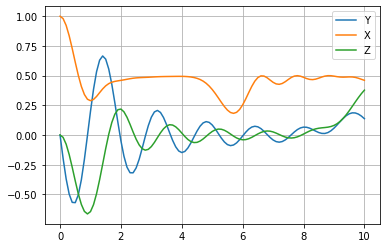

In [ ]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp,label='Y')
plt.plot(Time,x_exp,label='X')
plt.plot(Time,z_exp,label='Z')
plt.legend()
plt.grid()

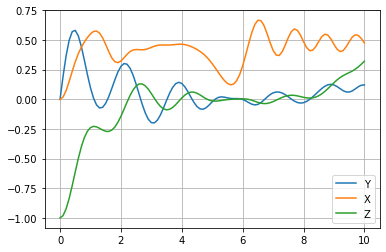

In [ ]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp_1,label='Y')
plt.plot(Time,x_exp_1,label='X')
plt.plot(Time,z_exp_1,label='Z')
plt.legend()
plt.grid()

In [ ]:
class DQNN(object):

    def __init__(self, qnnArch:list, device_name:str='default.mixed', interface:str='torch'):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
            device_name: name of the PennyLane device to use. Currently, only 'default.mixed' is supported
            interface: interface to use for the PennyLane device. Currently, only 'torch' is considered
        """
        self.qnnArch = qnnArch
        self.device_name = device_name
        self.interface = interface

    def makeRandomUnitaries(self, seed:int=None): # TODO: seed does nothing yet
        """ Randomly initialize unitary parameters """
        unitaries = []
        for l in range(len(self.qnnArch)-1):
            unitaries.append([])
            unitaries[l] = torch.randn(self.qnnArch[l+1], 4**(self.qnnArch[l]+1)-1, requires_grad=True)
        return unitaries

    def applyLayerChannel(self, unitaries:list, l:int, inputState):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # type check
        if isinstance(inputState, QuantumState) or len(inputState.shape) == 1:
            inputState = torch.tensor(DensityMatrix(inputState).data, requires_grad=False)
        for _ in outputWires:
            inputState = torch.kron(inputState, torch.tensor([[1, 0], [0, 0]], dtype=torch.complex128))

        @qml.qnode(device=qml.device(name=self.device_name, wires=numInputQubits+numOutputQubits), interface=self.interface)
        def layerChannel(inputState):
            qml.QubitDensityMatrix(inputState, wires=inputWires+outputWires)
            for j in range(numOutputQubits):
                qml.ArbitraryUnitary(weights=layerUnitaries[j], wires=inputWires+[outputWires[j]])
            return qml.density_matrix(wires=outputWires)

        return layerChannel(inputState)

    def forward(self, unitaries, inputs):
        """ Forward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: tensor of input states of shape (batch_size, input_dim, input_dim)

        Returns: 
            outputs: tensor of output states of shape (batch_size, output_dim, output_dim)
        """
        outputs = []
        for inputState in inputs:
            for l in range(len(self.qnnArch)-1):
                inputState = self.applyLayerChannel(unitaries, l, inputState)
            outputs.append(inputState)
        return torch.stack(outputs)

In [ ]:
def generate_random_training_data(numSamples:int, numInputQubits:int):
    """ Generate random training data 
    Args:
        numSamples: number of samples to generate
        numInputQubits: number of input qubits
    Returns:
        trainingData: list of random input states
    """
    trainingData = []
    for i in range(numSamples):
        trainingData.append(
            random_statevector(2**numInputQubits, seed=None) # TODO: seed
        )
    return trainingData

def generate_target_from_unitary(unitary:Operator, trainingData:list):
    """ Generate target states from a unitary
    Args:
        unitary: unitary to apply to the training data
        trainingData: list of input states
    Returns:
        targets: list of target states
    """
    targetStates = []
    for inputState in trainingData:
        targetStates.append(
            inputState.evolve(unitary).data
        )
    targetStates = np.array(targetStates)
    return torch.tensor(targetStates, requires_grad=False)

def cost(outputs, targets):
    """ Cost function to maximize
    Args:
        outputs: output states of the DQNN of shape (batch_size, output_dim, output_dim)
        targets: target states of shape (batch_size, output_dim)
    Returns:
        loss: average fidelity between output and target states
    """
    assert len(outputs) == len(targets), "outputs and targets must have the same length"
    loss = 0
    for output, target in zip(outputs, targets):
        #np_output=output.detach().numpy()
        #np_target=np.array(target)
        #loss += state_fidelity(DensityMatrix(np_output), DensityMatrix(np_target))
        #loss += #torch.real(torch.trace(torch.matmul(torch.conj(torch.transpose(target,0,1)), output)))/2#)torch.real(torch.vdot(target, output @ target))
        loss += qml.math.fidelity(target,output)
    return loss/len(outputs)

In [ ]:
#unitary = random_unitary(2**2)
deg_DM=2
model = DQNN([num_encoding*deg_DM, 2, 1])
unitaries = model.makeRandomUnitaries()
#trainingData = generate_random_training_data(10, 2)
#targetStates = generate_target_from_unitary(unitary, trainingData)
trainingData =train_data['input']#np.array(train_data['input'])#generate_random_training_data(10, 2, seed=0)
targetStates = train_data['output']

val_Data = val_data['input']
val_targetStates = val_data['output']

optimizer = torch.optim.Adam(unitaries, lr=0.01)

def closure():
    optimizer.zero_grad()
    outputs = model.forward(unitaries, trainingData)
    loss = 1-cost(outputs, targetStates)
    loss.backward()
    return loss

loss_list = []
loss_val_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(200):
    loss = optimizer.step(closure)
    writer.add_scalar('Loss', loss.item(), s)
    loss_list.append(loss.item())
    outputs = model.forward(unitaries, val_Data)
    loss = 1-cost(outputs, val_targetStates)
    loss_val_list.append(loss.item())

100%|██████████| 200/200 [3:02:02<00:00, 54.61s/it]


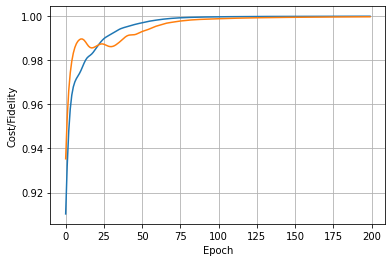

In [ ]:
from matplotlib import pyplot as plt
plt.plot(1-np.array(loss_list))
plt.plot(1-np.array(loss_val_list))
plt.xlabel('Epoch')
plt.ylabel('Cost/Fidelity')
plt.grid()

In [ ]:
val_Data = val_data['input']
val_targetStates = val_data['output']

In [ ]:
X=np.zeros((2,2),dtype=int)
Y=np.zeros((2,2),dtype=complex)
Z=np.zeros((2,2),dtype=int)
X[0,1]=X[1,0]=1
Y[0,1]=-1j
Y[1,0]=1j
Z[0,0]=1
Z[1,1]=-1
tot_data=trainingData+val_Data

outputs=model.forward(unitaries, tot_data)

In [ ]:
num=len(outputs)
X_predict=[x_exp[i] for i in range(num_encoding)]
Y_predict=[y_exp[i] for i in range(num_encoding)]
Z_predict=[z_exp[i] for i in range(num_encoding)]
for i in range(num):
    dm=outputs[i].detach().numpy()
    X_predict.append(np.real(np.trace(dm.dot(X))))
    Y_predict.append(np.real(np.trace(dm.dot(Y))))
    Z_predict.append(np.real(np.trace(dm.dot(Z))))

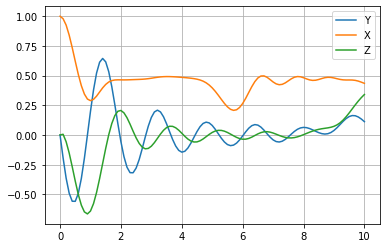

In [ ]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,Y_predict,label='Y')
plt.plot(Time,X_predict,label='X')
plt.plot(Time,Z_predict,label='Z')
plt.legend()
plt.grid()

In [ ]:
Z_predict=np.array(Z_predict)
X_predict=np.array(X_predict)
Y_predict=np.array(Y_predict)

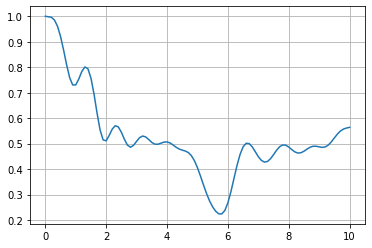

In [ ]:
Dist_R=np.sqrt(Y_predict**2+X_predict**2+Z_predict**2)
plt.plot(Time,Dist_R)
plt.grid()